<a href="https://colab.research.google.com/github/jackliu333/object_detection_using_tensorflow/blob/main/Training_Customised_Image_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Codes adapted from https://github.com/nicknochnack/TFODCourse/blob/main/2.%20Training%20and%20Detection.ipynb
# Images sampled from https://github.com/marcusklasson/GroceryStoreDataset, with bounding boxes drawn manually for each object
# To run using Google Colab; switch runtime type to GPU for speedup
import numpy as np
import random
import tensorflow as tf

SEED = 123
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Configuration parameters

Including paths and training hyper-parameters

In [ ]:
import os
print(f"Current OS: {os.name}") 

Current OS: posix


In [ ]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 

# SSD has good tradeoff between speed and accuracy; can switch to other pretrained model
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'

# TF official script to encode training data to tf record format
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'

# Mapping dictionary between label and integer id
LABEL_MAP_NAME = 'label_map.pbtxt'

# Define a list of folder paths to be created (if needed) and used later
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    # bounding box annotation
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
}

files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [ ]:
# create folder paths if not exist
for p in paths.values():
    if not os.path.exists(p):
        !mkdir -p {p}

# Set up TF model training logistics

### Download TF model training utility scripts from TF model zoo

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'objection_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

fatal: destination path 'Tensorflow/models' already exists and is not an empty directory.


### Install TF object detection library

May hit some error during installation, can be ignored, as long as it returns "OK" in the last line.

In [ ]:
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 


Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Processing /content/Tensorflow/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1654779 sha256=9255b19444cc0cfabd0a3daac811b65d578ed5af81bcd8e38e1ae5df0591a6cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-rr1wcuv7/wheels/ac/8a/90/02d8042c0333b38a96341f55d93b379bb170f98b196de6b536
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [ ]:
# Verify installation
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
!python {VERIFICATION_SCRIPT}

2021-06-22 00:17:12.160583: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Running tests under Python 3.7.10: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2021-06-22 00:17:13.879206: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-06-22 00:17:13.907606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-22 00:17:13.908211: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-06-22 00:17:13.908252: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfull

In [ ]:
# test if TF object detection library could be loaded
import object_detection

### Download and decompress TF pretrained model

In [ ]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

--2021-06-22 00:17:39--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.142.128, 2607:f8b0:400e:c00::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.142.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  --.-KB/s    in 0.1s    

2021-06-22 00:17:39 (164 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]

ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8

### Download training images

In [ ]:
import shutil

if os.path.exists('object_detection_using_tensorflow'):
    shutil.rmtree('object_detection_using_tensorflow')

!git clone https://github.com/jackliu333/object_detection_using_tensorflow.git

Cloning into 'object_detection_using_tensorflow'...
remote: Enumerating objects: 341, done.
remote: Counting objects: 100% (341/341), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 341 (delta 215), reused 298 (delta 181), pack-reused 0
Receiving objects: 100% (341/341), 1.51 MiB | 24.20 MiB/s, done.
Resolving deltas: 100% (215/215), done.


### Create label map

In [ ]:
labels = [{'name':'Apple', 'id':1},
          {'name':'Avocado', 'id':2},
          {'name':'Banana', 'id':3},
          {'name':'Cabbage', 'id':4},
          {'name':'Carrot', 'id':5},
          {'name':'Potato', 'id':6}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

### Split into train test folders

In [ ]:
tmp_folders = ['train', 'test']

for i in tmp_folders:
    if os.path.exists(os.path.join(paths['IMAGE_PATH'], i)):
        shutil.rmtree(os.path.join(paths['IMAGE_PATH'], i))
        !mkdir -p {os.path.join(paths['IMAGE_PATH'], i)}
    else:
        !mkdir -p {os.path.join(paths['IMAGE_PATH'], i)}

In [ ]:
import shutil

for i in range(len(labels)):
    # print(labels[i]['name'])
    from_path = os.path.join('object_detection_using_tensorflow','images',labels[i]['name'])
    # print(from_path)

    # get unique file names
    tmp_files = os.listdir(from_path)
    tmp_names = []
    tmp_file_types = []
    for tmp_file in tmp_files:
        tmp_name = os.path.splitext(tmp_file)[0]
        tmp_file_type = os.path.splitext(tmp_file)[1]
        tmp_names.append(tmp_name)
        tmp_file_types.append(tmp_file_type)
    tmp_names = list(set(tmp_names))
    tmp_names = [i for i in tmp_names if i != '.DS_Store']
    tmp_file_types = list(set(tmp_file_types))
    tmp_file_types = [i for i in tmp_file_types if len(i) != 0]
    # random shuffle the files
    random.shuffle(tmp_names)
    
    # training and test files
    tmp_names_train = tmp_names[0:int(len(tmp_names)*0.9)]
    tmp_names_test = [i for i in tmp_names if i not in tmp_names_train]

    # move into respective target folders
    for tmp_name in tmp_names_train:
        for tmp_file_type in tmp_file_types:
            tmp_name_full = tmp_name + tmp_file_type
            shutil.copy(os.path.join(from_path, tmp_name_full), \
                        os.path.join(paths['IMAGE_PATH'], "train"))

    for tmp_name in tmp_names_test:
        for tmp_file_type in tmp_file_types:
            tmp_name_full = tmp_name + tmp_file_type
            shutil.copy(os.path.join(from_path, tmp_name_full), \
                        os.path.join(paths['IMAGE_PATH'], "test"))

### Create TF Record

In [ ]:
# download conversion script
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [ ]:
# convert to TF record format
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record
Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record


### Copy model configuration file to training folder

In [ ]:
!cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {paths['CHECKPOINT_PATH']}

### Update configuration file for transfer learning

In [ ]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

# Read current configuration file
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

# Update based on new labels
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

# Write to configuration file
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# Model training

In [ ]:
# fix opencv-python version issue 
!pip uninstall opencv-python-headless 
!pip install opencv-python-headless==4.1.2.30

In [ ]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])
!{command}

2021-06-22 00:17:46.490778: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-06-22 00:17:48.409074: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-06-22 00:17:48.438832: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-22 00:17:48.439458: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-06-22 00:17:48.439509: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-06-22 00:17:48.442110: I tensorflow/stream_executor/platform/default

# (Optional) Model evaluation

In [ ]:
# stop evaluation if needed
# command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])
# !{command}

# Predicting object category in image

### Load trained model from checkpoint

In [ ]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-3')).expect_partial()

# @tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

### Detect objects in image

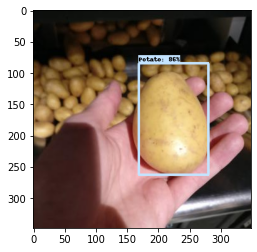

In [ ]:
import cv2 
from matplotlib import pyplot as plt
%matplotlib inline

# Randomly select an image to be detected
tmp_img = random.choice([file for file in os.listdir(os.path.join(paths['IMAGE_PATH'], 
                                              'test')) if file.endswith(".jpg")])
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', tmp_img)

category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.5,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()